# Modeling likelihood responses

Models for the probabilities of $P(sensation|pain)$ and $P(sensation|nopain)$

In [1]:
import sumProduct as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

In [2]:
data=np.genfromtxt('PI-ANNA_DatenN=36CSV.csv', delimiter=";",skip_header=2,dtype=str)
type(data[1,1])

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i,j]=str(data[i,j]).replace(",",".")
        
data_sens_pain=data[:,5:11].astype('float')

In [3]:
# 3 Kategorien von sens|pain, <30, 30-64, >64
x=data_sens_pain
A=(x<30).astype('float')*15 + (x>64).astype('float')*75
A[A < .1] = 50

In [4]:
def transform_value(val):
    if val==75.:
        return('yes')
    elif val==50.:
        return('maybe')
    elif val==15.:
        return('no')

In [5]:
allvp=[]
idx=0
for vp in A: 
    new_vp=dict()
    new_vp['pain']=[transform_value(x) for x in vp[:3]]
    new_vp['nopain']=[transform_value(x) for x in vp[3:]]
    new_vp['health']=idx>15
    idx+=1
    allvp.append(new_vp)

# Basic Model 1
No differences between type of sensations

Pain state is not considered!

In [6]:
def buildbasicmodel():
    s=sp.variableNode(name='S1', vrange=['yes','maybe','no'])
    variable=[s]
    u=sp.freeEnergyFactorNode()
    u.addNeighbour(s)
    factor=[u]
    
    def basicprior(condrv,conditioners):
        if condrv[0] is None:
            return 10.0
        if condrv[0]=='yes':
            return 0.3333
        if condrv[0]=='maybe':
            return 0.333
        if condrv[0]=='no':
            return 0.333
    u.setPrior(basicprior)
    allNodes=[s,u]
    
    return(allNodes,variable,factor)

In [7]:
def basicmodelevidence():#equal_model=False,individual_model=False
    
    
    modelEvidence_healthy=0.0
    modelEvidence_sick=0.0
    modelEvidence_all=0.0
    modelEvidence_individual=0.0
    
    #if individual_model==True:
    
    for vp in allvp: 

        allNodes,variables,factors=buildbasicmodel()

        sp.startLearning(allNodes)
        for state in ['pain','nopain']:
            for v in vp[state]:
                variables[0].observe(v)
                sp.runSumProduct(allNodes)
                logp=np.log(variables[0].marginal()[-1])
                modelEvidence_individual+=logp
                sp.accumulateEvidence(allNodes)
        sp.learn(allNodes)
        modelEvidence_individual+=factors[0].KLDiv_post_prior
                
    #if equal_model==True:
        
    allNodes_sick,variables_sick,factors_sick=buildbasicmodel()
    allNodes_healthy,variables_healthy,factors_healthy=buildbasicmodel()
    allNodes_all,variables_all,factors_all=buildbasicmodel()

    sp.startLearning(allNodes_sick)
    sp.startLearning(allNodes_healthy)
    sp.startLearning(allNodes_all)

    for vp in allvp: 

        for state in ['pain','nopain']:
            for v in vp[state]:
                variables_all[0].observe(v)
                sp.runSumProduct(allNodes_all)
                logp=np.log(variables_all[0].marginal()[-1])
                modelEvidence_all+=logp
                sp.accumulateEvidence(allNodes_all)


        if vp['health']:
            for state in ['pain','nopain']:
                for v in vp[state]:
                    variables_healthy[0].observe(v)
                    sp.runSumProduct(allNodes_healthy)
                    logp=np.log(variables_healthy[0].marginal()[-1])
                    modelEvidence_healthy+=logp
                    sp.accumulateEvidence(allNodes_healthy)


        elif vp['health']==False:
            for state in ['pain','nopain']:
                for v in vp[state]:
                    variables_sick[0].observe(v)
                    sp.runSumProduct(allNodes_sick)
                    logp=np.log(variables_sick[0].marginal()[-1])
                    modelEvidence_sick+=logp
                    sp.accumulateEvidence(allNodes_sick)

    sp.learn(allNodes_healthy)
    modelEvidence_healthy+=factors_healthy[0].KLDiv_post_prior
    sp.learn(allNodes_sick)
    modelEvidence_sick+=factors_sick[0].KLDiv_post_prior
    sp.learn(allNodes_all)
    modelEvidence_all+=factors_all[0].KLDiv_post_prior
        
                
    return(modelEvidence_healthy,modelEvidence_sick,modelEvidence_all,modelEvidence_individual)



In [8]:
EviBasicequal_healthy,EviBasicequal_sick,EviBasicequal_all,EviBasic_perperson= basicmodelevidence()

starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
learning for 2 nodes
starting learning for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
accumulating evidence for 2 nodes
Runing Sum-product
a

In [9]:
evidences_basic=[EviBasicequal_healthy+EviBasicequal_sick,EviBasicequal_all,EviBasic_perperson]

In [10]:
posterior_basic=[]
Pd_m_basic=[]

for a in evidences_basic:
    Pd_m_basic+=[np.exp(a)*1/len(evidences_basic)]
P_d_basic=sum(Pd_m_basic)

for c in Pd_m_basic:
    posterior_basic.append(c/P_d_basic)
posterior_basic

[0.31869013867784274, 0.11964869255371643, 0.5616611687684407]

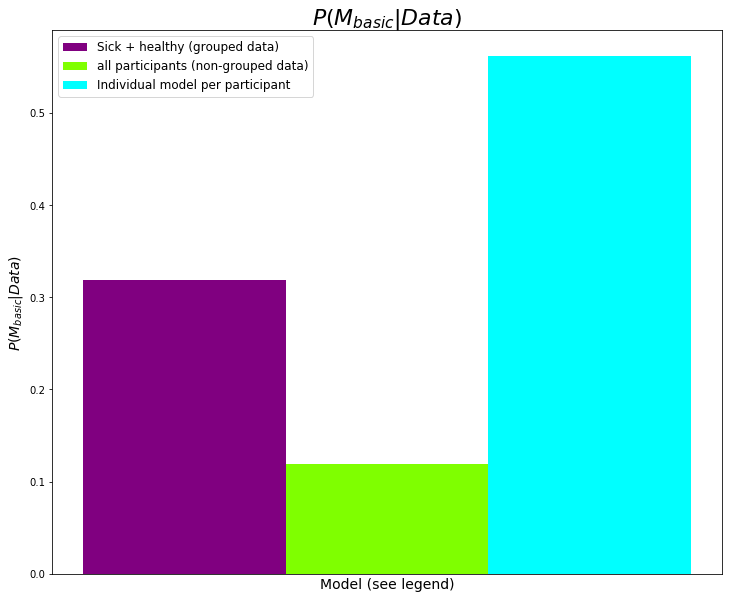

In [11]:
plt.figure(figsize=(12.0,10.0))
plt.title(r'$P(M_{basic}|Data)$',fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'$P(M_{basic}|Data)$',fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_basic[0], bar_width, color='purple', label='Sick + healthy (grouped data)')
plt.bar(index+bar_width, posterior_basic[1], bar_width, color='chartreuse', label='all participants (non-grouped data)')
plt.bar(index+2*bar_width, posterior_basic[2], bar_width, color='cyan', label='Individual model per participant')

plt.legend(fontsize=12)
plt.savefig('evi_basic_grouped.png')
plt.show()


In [12]:
posterior_basic

[0.31869013867784274, 0.11964869255371643, 0.5616611687684407]

# ------------------------------------------------------------------------------

# Basic specific model

In [13]:
def buildbasicspecificmodel():
    belly=sp.variableNode(name='bellynode', vrange=['yes','maybe','no'])
    neck=sp.variableNode(name='necknode',vrange=['yes','maybe','no'])
    hand=sp.variableNode(name='handnode',vrange=['yes','maybe','no'])
    
    variables=[belly,neck,hand]
    
    be=sp.freeEnergyFactorNode()
    be.addNeighbour(variables[0])
    
    ne=sp.freeEnergyFactorNode()
    ne.addNeighbour(variables[1])
    
    ha=sp.freeEnergyFactorNode()
    ha.addNeighbour(variables[2])
    
    factors=[be,ne,ha]
    
    def basicprior(condrv,conditioners):
        if condrv[0] is None:
            return 10.0
        if condrv[0]=='yes':
            return 0.3333
        if condrv[0]=='maybe':
            return 0.333
        if condrv[0]=='no':
            return 0.333
    be.setPrior(basicprior)
    ne.setPrior(basicprior)
    ha.setPrior(basicprior)
    
    allNodes=variables+factors
    
    return(allNodes,variables,factors)


In [14]:
def evidencespecificbasic(): #equal_model=False,individual_model=False
    
    modelEvidence_healthy=0.0
    modelEvidence_sick=0.0
    modelEvidence_all=0.0
    modelEvidence_individual=0.0
    
    #if equal_model==True: 
        
    allNodes_sick,variables_sick,factors_sick=buildbasicspecificmodel()
    allNodes_healthy,variables_healthy,factors_healthy=buildbasicspecificmodel()
    allNodes_all,variables_all,factors_all=buildbasicspecificmodel()

    sp.startLearning(allNodes_sick)
    sp.startLearning(allNodes_healthy)
    sp.startLearning(allNodes_all)

    for vp in allvp:

        for state in ['pain','nopain']:

            b,n,h=vp[state]
            variables_all[0].observe(b)
            variables_all[1].observe(n)
            variables_all[2].observe(h)
            sp.runSumProduct(allNodes_all)
            logp=np.log(variables_all[0].marginal()[-1])
            modelEvidence_all+=logp
            sp.accumulateEvidence(allNodes_all)


        if vp['health']:
            for state in ['pain','nopain']:

                b,n,h=vp[state]
                variables_healthy[0].observe(b)
                variables_healthy[1].observe(n)
                variables_healthy[2].observe(h)
                sp.runSumProduct(allNodes_healthy)
                logp=np.log(variables_healthy[0].marginal()[-1]) 
                modelEvidence_healthy+=logp
                sp.accumulateEvidence(allNodes_healthy)

        if vp['health']==False:
            for state in ['pain','nopain']:

                b,n,h=vp[state]
                variables_sick[0].observe(b)
                variables_sick[1].observe(n)
                variables_sick[2].observe(h)
                sp.runSumProduct(allNodes_sick)
                logp=np.log(variables_sick[0].marginal()[-1])
                modelEvidence_sick+=logp

                sp.accumulateEvidence(allNodes_sick)


    sp.learn(allNodes_all)
    modelEvidence_all+=factors_all[0].KLDiv_post_prior
    sp.learn(allNodes_healthy)
    modelEvidence_healthy+=factors_healthy[0].KLDiv_post_prior
    sp.learn(allNodes_sick)
    modelEvidence_sick+=factors_sick[0].KLDiv_post_prior


#if individual_model==True:

    for vp in allvp: 

        allNodes,variables,factors=buildbasicspecificmodel()

        sp.startLearning(allNodes)

        for state in ['pain','nopain']:

            b,n,h=vp[state]
            variables[0].observe(b)
            variables[0].observe(n)
            variables[0].observe(h)
            sp.runSumProduct(allNodes)
            logp=np.log(variables[0].marginal()[-1])
            modelEvidence_individual+=logp

            sp.accumulateEvidence(allNodes)
        sp.learn(allNodes)
        modelEvidence_individual+=factors[0].KLDiv_post_prior


    return(modelEvidence_all,modelEvidence_healthy,modelEvidence_sick,modelEvidence_individual)

In [15]:
EviSpecequal_all,EviSpecequal_sick,EviSpecequal_healthy,EviSpec_perperson=evidencespecificbasic()

starting learning for 6 nodes
starting learning for 6 nodes
starting learning for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Sum-product
accumulating evidence for 6 nodes
Runing Su

In [16]:
evidences_specific=[EviSpecequal_all,EviSpecequal_sick+EviSpecequal_healthy,EviSpec_perperson]

In [17]:
Pd_m_basicspec=[]
posterior_basicspec=[]

for p in evidences_specific:
    Pd_m_basicspec+=[np.exp(p)*1/len(evidences_specific)]
P_d_basicspec=sum(Pd_m_basicspec)

for i in Pd_m_basicspec:
    posterior_basicspec.append(i/P_d_basicspec)
    
posterior_basicspec

[0.34954384266085575, 0.4631486084463844, 0.18730754889275986]

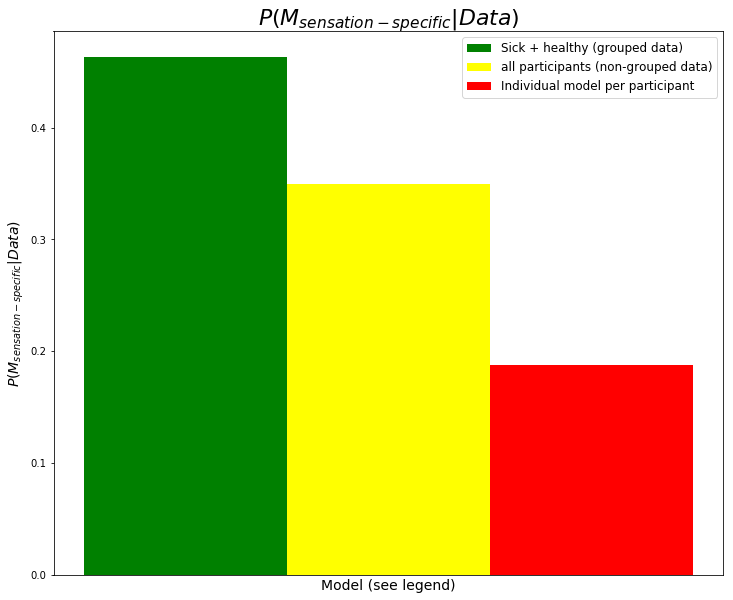

In [18]:
plt.figure(figsize=(12.0,10.0))
plt.title(r'$P(M_{sensation-specific}|Data)$',fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'$P(M_{sensation-specific}|Data)$',fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_basicspec[1], bar_width, color='green', label='Sick + healthy (grouped data)')
plt.bar(index+bar_width, posterior_basicspec[0], bar_width, color='yellow', label='all participants (non-grouped data)')
plt.bar(index+2*bar_width, posterior_basicspec[2], bar_width, color='red', label='Individual model per participant')

plt.legend(fontsize=12)
plt.savefig('evi_basicspec_grouped.png')
plt.show()


In [19]:
posterior_basicspec

[0.34954384266085575, 0.4631486084463844, 0.18730754889275986]

In [20]:
posterior_basicspec[1]/posterior_basicspec[0]

1.325008631022442

# ------------------------------------------------------------

# Hierarchical Model

In [21]:
def buildhierarchicalmodel():
    belly=sp.variableNode(name='bauch', vrange=['yes','maybe','no'])
    neck=sp.variableNode(name='neck', vrange=['yes','maybe','no'])
    hand=sp.variableNode(name='hand',vrange=['yes','maybe','no'])
    variables=[belly,neck,hand]

    pain=sp.variableNode(name='pain',vrange=['pain','nopain'])
    variables.append(pain)

    b=sp.freeEnergyFactorNode()
    b.addNeighbour(belly)
    b.addNeighbour(pain,isConditioner=True)
    
    n=sp.freeEnergyFactorNode()
    n.addNeighbour(neck)
    n.addNeighbour(pain,isConditioner=True)
    
    h=sp.freeEnergyFactorNode()
    h.addNeighbour(hand)
    h.addNeighbour(pain,isConditioner=True)
    
    p=sp.freeEnergyFactorNode()
    p.addNeighbour(pain)
    
    print(b.conditionedRanges,n.ranges,h.ranges)

    def sensprior(condrv,conditioners):
        if condrv[0] is None:
            return 10.0
        if conditioners[0]=='pain':
            if condrv[0]=='yes':
                return 0.333
            if condrv[0]=='maybe':
                return 0.333
            if condrv[0]=='no':
                return 0.333
        if conditioners[0]=='nopain':
            if condrv[0]=='yes':
                return 0.333
            if condrv[0]=='maybe':
                return 0.333
            if condrv[0]=='no':
                return 0.333
        raise RuntimeError('Fehler',conditioners[0],condrv[0])
            
    def painprior(condrv,conditioners):
        if condrv[0] is None:
            return 10.0
        if condrv[0]=='nopain':
            return 0.5
        if condrv[0]=='pain':
            return 0.5
        raise RuntimeError('Fehler')

    b.setPrior(sensprior)
    n.setPrior(sensprior)
    h.setPrior(sensprior)
    p.setPrior(painprior)
    

    factors=[b,n,h,p]
    allNodes=variables+factors

    return (allNodes,belly,neck,hand,pain,factors)
    

In [22]:
def evidencehierarchicalmodel():
    
    modelEvidence_healthy=0.0
    modelEvidence_sick=0.0
    modelEvidence_all=0.0
    modelEvidence_individual=0.0
    
    
    ######################################## Per person #########################################
    
    for vp in allvp: 
        allNodes_individual,belly_individual,neck_individual,hand_individual,pain_individual,factors_individual=buildhierarchicalmodel()
        
        sp.startLearning(allNodes_individual)
        
        for state in ['pain','nopain']:
            b,n,h=vp[state]
            pain_individual.observe(state)
            belly_individual.observe(b)
            neck_individual.observe(n)
            hand_individual.observe(h)
            
            sp.runSumProduct(allNodes_individual)
            
            logp=np.log(belly_individual.marginal()[-1])
            modelEvidence_individual+=logp
            sp.accumulateEvidence(allNodes_individual)
        sp.learn(allNodes_individual)
        modelEvidence_individual+=factors_individual[0].KLDiv_post_prior
        
        
    ########################################### equal model #######################################
        
        
    allNodes_sick,belly_sick,neck_sick,hand_sick,pain_sick,factors_sick=buildhierarchicalmodel()
    allNodes_healthy,belly_healthy,neck_healthy,hand_healthy,pain_healthy,factors_healthy=buildhierarchicalmodel()
    allNodes_all,belly_all,neck_all,hand_all,pain_all,factors_all=buildhierarchicalmodel()
    
    sp.startLearning(allNodes_sick)
    sp.startLearning(allNodes_healthy)
    sp.startLearning(allNodes_all)
    
    
    for vp in allvp:

        for state in ['pain','nopain']:

            b,n,h=vp[state]
            pain_all.observe(state)
            belly_all.observe(b)
            neck_all.observe(n)
            hand_all.observe(h)
            sp.runSumProduct(allNodes_all)
            logp=np.log(belly_all.marginal()[-1])
            modelEvidence_all+=logp
            sp.accumulateEvidence(allNodes_all)


        if vp['health']:
            for state in ['pain','nopain']:

                b,n,h=vp[state]
                pain_healthy.observe(state)
                belly_healthy.observe(b)
                neck_healthy.observe(n)
                hand_healthy.observe(h)
                sp.runSumProduct(allNodes_healthy)
                logp=np.log(belly_healthy.marginal()[-1]) 
                modelEvidence_healthy+=logp
                sp.accumulateEvidence(allNodes_healthy)

        if vp['health']==False:
            for state in ['pain','nopain']:

                b,n,h=vp[state]
                pain_sick.observe(state)
                belly_sick.observe(b)
                neck_sick.observe(n)
                hand_sick.observe(h)
                sp.runSumProduct(allNodes_sick)
                logp=np.log(belly_sick.marginal()[-1])
                modelEvidence_sick+=logp

                sp.accumulateEvidence(allNodes_sick)


    sp.learn(allNodes_all)
    modelEvidence_all+=factors_all[0].KLDiv_post_prior
    sp.learn(allNodes_healthy)
    modelEvidence_healthy+=factors_healthy[0].KLDiv_post_prior
    sp.learn(allNodes_sick)
    modelEvidence_sick+=factors_sick[0].KLDiv_post_prior
    
    
    return(modelEvidence_sick,modelEvidence_healthy,modelEvidence_all,modelEvidence_individual)
            

In [23]:
EviHyequal_sick,EviHyequal_healthy,EviHyequal_all,EviHy_perperson=evidencehierarchicalmodel()

[('yes',), ('maybe',), ('no',)] None None
starting learning for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
learning for 8 nodes
[('yes',), ('maybe',), ('no',)] None None
starting learning for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
learning for 8 nodes
[('yes',), ('maybe',), ('no',)] None None
starting learning for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
learning for 8 nodes
[('yes',), ('maybe',), ('no',)] None None
starting learning for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
learning for 8 nodes
[('yes',), ('maybe',), ('no',)] None None
starting learning for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
Runing Sum-product
accumulating evidence for 8 nodes
learning for 8 nodes
[('ye

In [24]:
evidences_hierarchical=[EviHyequal_sick+EviHyequal_healthy,EviHyequal_all,EviHy_perperson]

Pd_m_hy=[]
posterior_hy=[]

for p in evidences_hierarchical:
    Pd_m_hy+=[np.exp(p)*1/len(evidences_hierarchical)]
P_d_hy=sum(Pd_m_hy)

for i in Pd_m_hy:
    posterior_hy.append(i/P_d_hy)
    
posterior_hy

[0.4523470270639764, 0.41597388678096786, 0.13167908615505575]

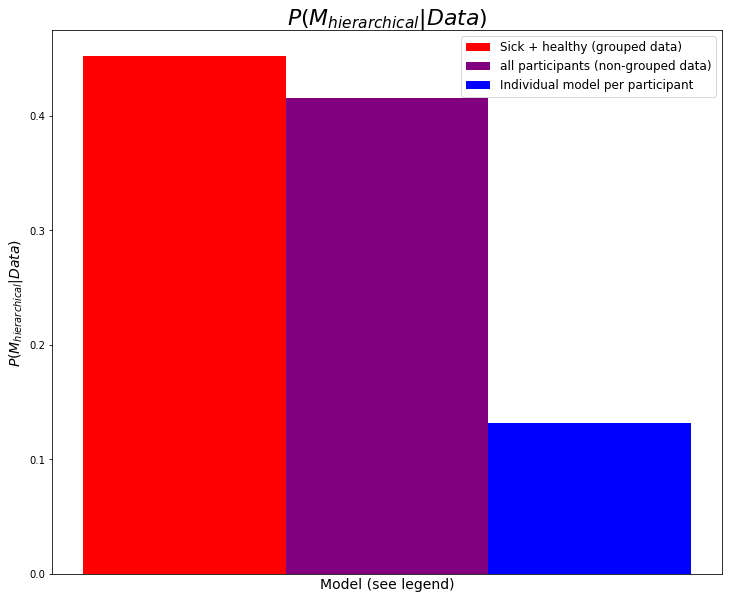

In [25]:
plt.figure(figsize=(12.0,10.0))
plt.title(r'$P(M_{hierarchical}|Data)$',fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'$P(M_{hierarchical}|Data)$',fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_hy[0], bar_width, color='red', label='Sick + healthy (grouped data)')
plt.bar(index+bar_width, posterior_hy[1], bar_width, color='purple', label='all participants (non-grouped data)')
plt.bar(index+2*bar_width, posterior_hy[2], bar_width, color='blue', label='Individual model per participant')

plt.legend(fontsize=12)
plt.savefig('evi_hierarchical_grouped.png')
plt.show()


In [26]:
posterior_hy

[0.4523470270639764, 0.41597388678096786, 0.13167908615505575]

In [27]:
# Posterior f端r alle combined models...? 

evidence_grouped=[EviBasicequal_healthy+EviBasicequal_sick,EviSpecequal_healthy+EviSpecequal_sick,EviHyequal_healthy+EviHyequal_sick]

Pd_m_grouped=[]
posterior_grouped=[]

for p in evidence_grouped:
    Pd_m_grouped+=[np.exp(p)*1/len(evidence_grouped)]
P_d_grouped=sum(Pd_m_grouped)

for i in Pd_m_grouped:
    posterior_grouped.append(i/P_d_grouped)
    
posterior_grouped

[7.228908518620311e-67, 1.0, 1.475454891107714e-88]

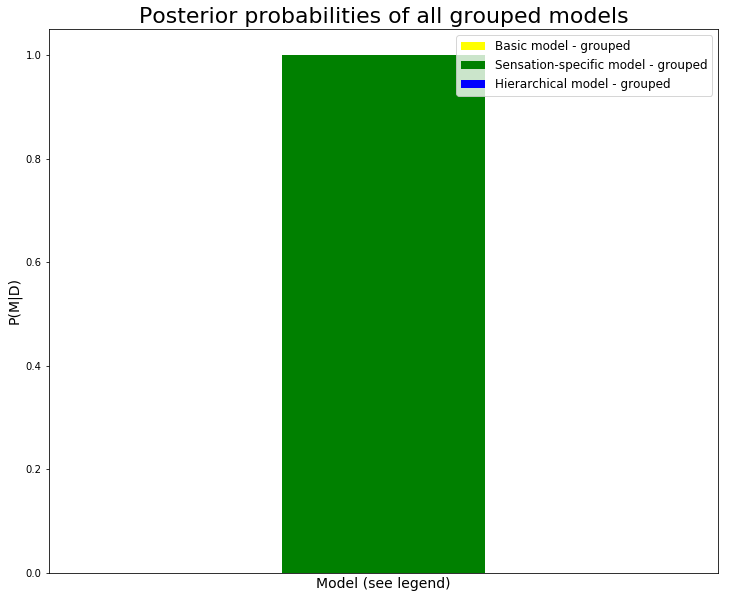

In [28]:
plt.figure(figsize=(12.0,10.0))
plt.title('Posterior probabilities of all grouped models', fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'P(M|D)', fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_grouped[0], bar_width, color='yellow', label='Basic model - grouped')
plt.bar(index+bar_width, posterior_grouped[1], bar_width, color='green', label='Sensation-specific model - grouped')
plt.bar(index+2*bar_width, posterior_grouped[2], bar_width, color='blue', label='Hierarchical model - grouped')

plt.legend(fontsize=12)
plt.savefig('evi_all_sick+healthy_models.png')
plt.show()



Bayes factors berechnen: und in eine Tabelle packen. 

alle gegen den ganzen Rest: das ist der einzig wirklich interessante bayes factor

In [29]:
# Posterior f端r alle perperson models...? 

evidence_perperson=[EviBasic_perperson,EviSpec_perperson,EviHy_perperson]
Pd_m_perperson=[]
posterior_perperson=[]

for p in evidence_perperson:
    Pd_m_perperson+=[np.exp(p)*1/len(evidence_perperson)]
P_d_perperson=sum(Pd_m_perperson)

for i in Pd_m_perperson:
    posterior_perperson.append(i/P_d_perperson)
    
posterior_perperson

[3.1502395949980827e-66, 1.0, 1.0620282832491237e-88]

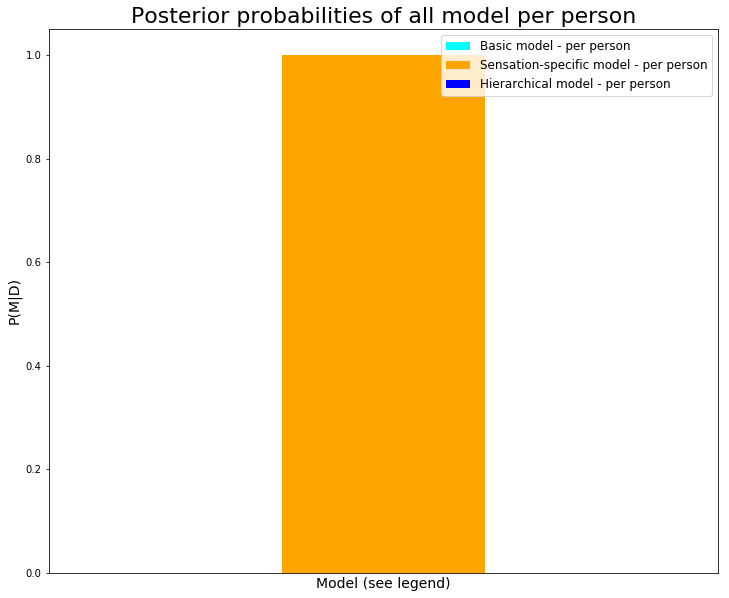

In [30]:
plt.figure(figsize=(12.0,10.0))
plt.title('Posterior probabilities of all model per person', fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'P(M|D)', fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_perperson[0], bar_width, color='cyan', label='Basic model - per person')
plt.bar(index+bar_width, posterior_perperson[1], bar_width, color='orange', label='Sensation-specific model - per person')
plt.bar(index+2*bar_width, posterior_perperson[2], bar_width, color='blue', label='Hierarchical model - per person')

plt.legend(fontsize=12)
plt.savefig('evi_all_sick+healthy_models.png')
plt.show()



In [31]:
# Posterior f端r alle sick? 

evidence_sick=[EviBasicequal_sick,EviSpecequal_sick,EviHyequal_sick]
Pd_m_sick=[]
posterior_sick=[]

for p in evidence_sick:
    Pd_m_sick+=[np.exp(p)*1/len(evidence_sick)]
P_d_sick=sum(Pd_m_sick)

for i in Pd_m_sick:
    posterior_sick.append(i/P_d_sick)
    
posterior_sick


[4.0348536797021155e-28, 1.0, 4.580108822411416e-38]

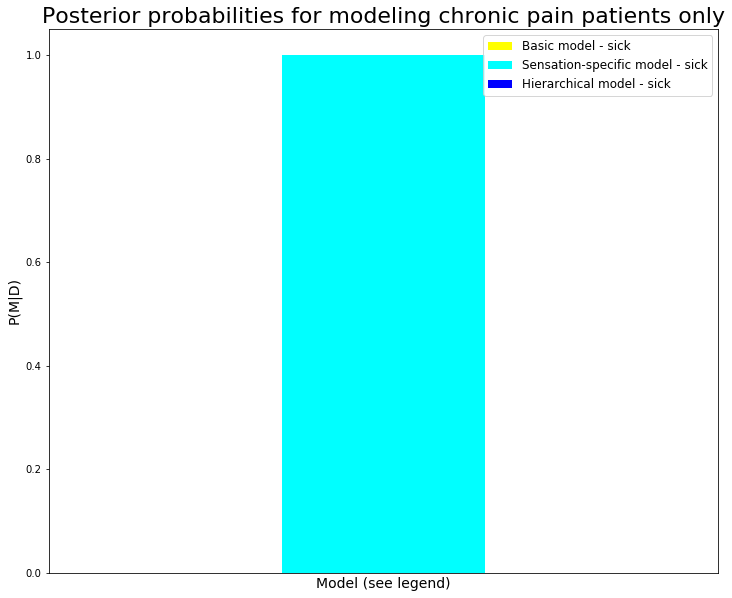

In [32]:
plt.figure(figsize=(12.0,10.0))
plt.title('Posterior probabilities for modeling chronic pain patients only', fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'P(M|D)', fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_sick[0], bar_width, color='yellow', label='Basic model - sick')
plt.bar(index+bar_width, posterior_sick[1], bar_width, color='cyan', label='Sensation-specific model - sick')
plt.bar(index+2*bar_width, posterior_sick[2], bar_width, color='blue', label='Hierarchical model - sick')

plt.legend(fontsize=12)
plt.savefig('evi_all_sick_models.png')
plt.show()



In [33]:
# Posterior 端ber alle Modelle

evidences_allmodels=[EviBasicequal_healthy+EviBasicequal_sick,EviBasicequal_all,EviBasic_perperson,
                     EviSpecequal_sick+EviSpecequal_healthy,EviSpecequal_all,EviSpec_perperson,
                     EviHyequal_sick+EviHyequal_healthy,EviHyequal_all,EviHy_perperson]

Pd_m_allmodels=[]
posterior_allmodels=[]

for p in evidences_allmodels:
    Pd_m_allmodels+=[np.exp(p)*1/len(evidences_allmodels)]
P_d_allmodels=sum(Pd_m_allmodels)

for i in Pd_m_allmodels:
    posterior_allmodels.append(i/P_d_allmodels)
    
posterior_allmodels


[3.3480589209852107e-67,
 1.2569917417295302e-67,
 5.900636569640113e-67,
 0.4631486084463844,
 0.34954384266085575,
 0.18730754889275986,
 6.833548796419493e-89,
 6.284064409142207e-89,
 1.9892591459017907e-89]

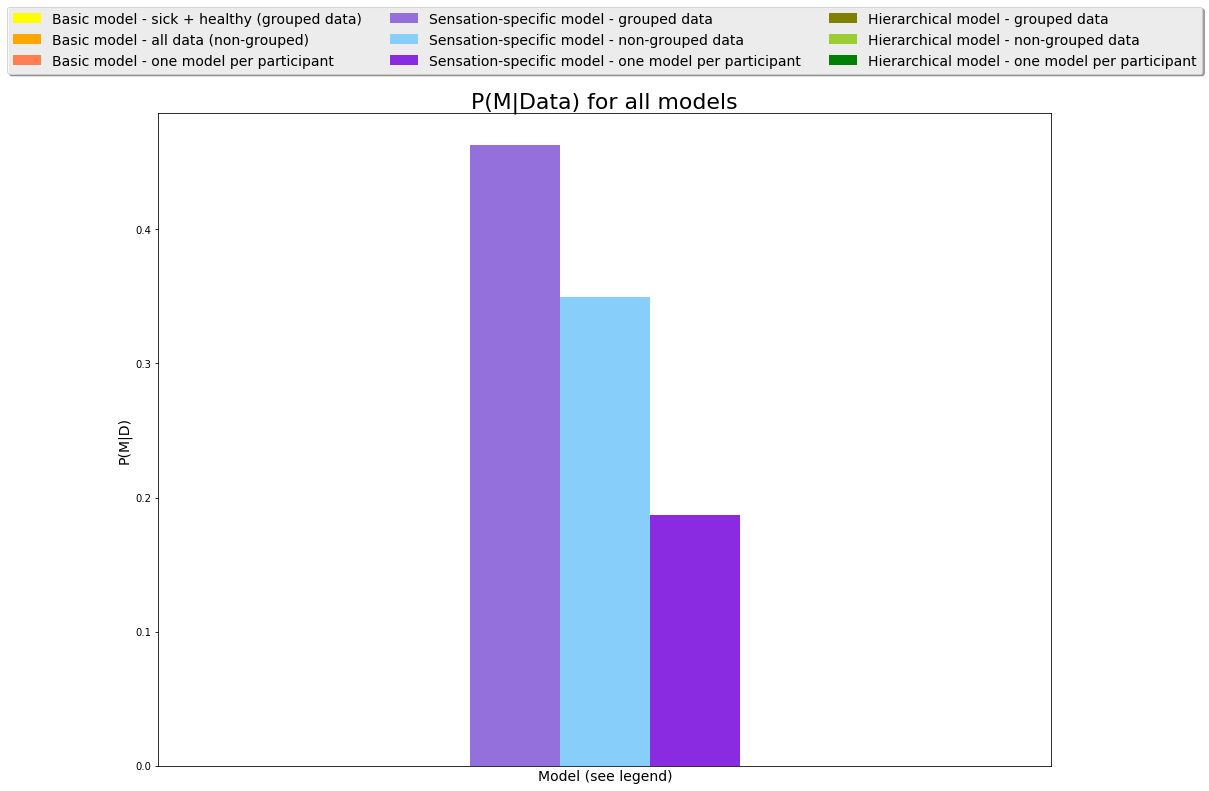

In [34]:
plt.figure(figsize=(16.0,12.0))
plt.title(r'P(M|Data) for all models', fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'P(M|D)', fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, posterior_allmodels[0], bar_width, color='yellow', label='Basic model - sick + healthy (grouped data)')
plt.bar(index+bar_width, posterior_allmodels[1], bar_width, color='orange', label='Basic model - all data (non-grouped)')
plt.bar(index+2*bar_width, posterior_allmodels[2], bar_width, color='coral', label='Basic model - one model per participant')
plt.bar(index+3*bar_width, posterior_allmodels[3], bar_width, color='mediumpurple', label='Sensation-specific model - grouped data')
plt.bar(index+4*bar_width, posterior_allmodels[4], bar_width, color='lightskyblue', label='Sensation-specific model - non-grouped data')
plt.bar(index+5*bar_width, posterior_allmodels[5], bar_width, color='blueviolet', label='Sensation-specific model - one model per participant')
plt.bar(index+6*bar_width, posterior_allmodels[6], bar_width, color='olive', label='Hierarchical model - grouped data')
plt.bar(index+7*bar_width, posterior_allmodels[7], bar_width, color='yellowgreen', label='Hierarchical model - non-grouped data')
plt.bar(index+8*bar_width, posterior_allmodels[8], bar_width, color='g', label='Hierarchical model - one model per participant')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=14)
plt.savefig('evi_all_sick_models.png')
plt.show()



In [35]:
#EviBasicequal_healthy+EviBasicequal_sick,EviBasicequal_all,EviBasic_perperson,
# EviSpecequal_sick+EviSpecequal_healthy,EviSpecequal_all,EviSpec_perperson,
# EviHyequal_sick+EviHyequal_healthy,EviHyequal_all,EviHy_perperson]

In [36]:
posterior_allmodels

[3.3480589209852107e-67,
 1.2569917417295302e-67,
 5.900636569640113e-67,
 0.4631486084463844,
 0.34954384266085575,
 0.18730754889275986,
 6.833548796419493e-89,
 6.284064409142207e-89,
 1.9892591459017907e-89]

In [41]:
post_grouped=posterior_allmodels[0]+posterior_allmodels[3]+posterior_allmodels[6]

In [42]:
post_nongrouped=posterior_allmodels[1]+posterior_allmodels[4]+posterior_allmodels[7]
post_individual=posterior_allmodels[2]+posterior_allmodels[5]+posterior_allmodels[8]

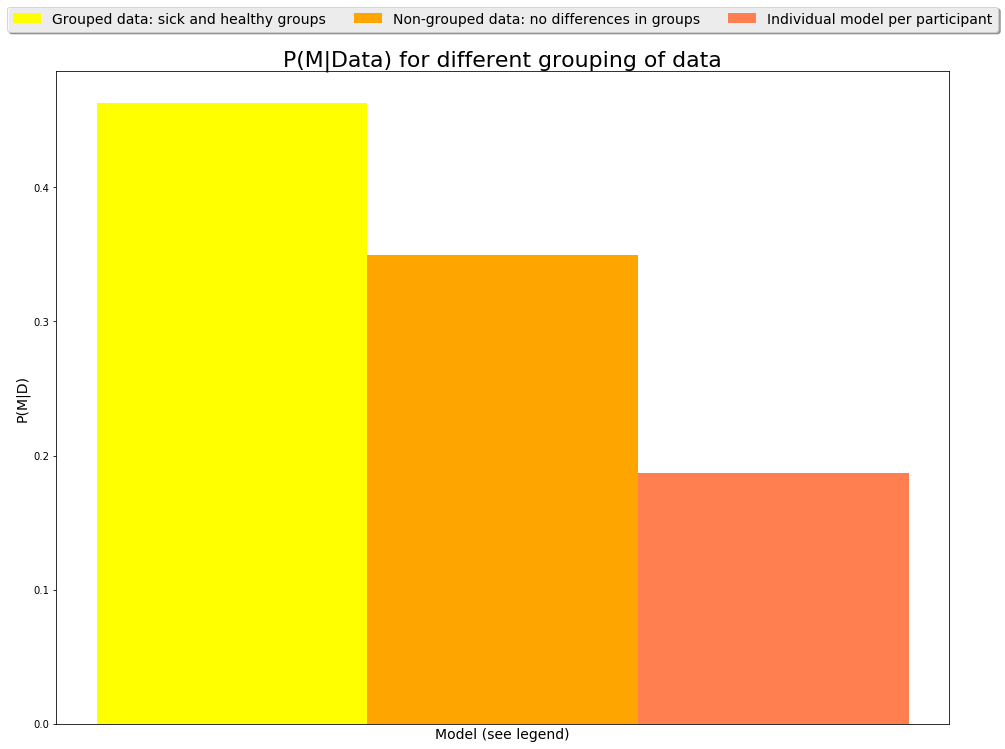

In [45]:
plt.figure(figsize=(16.0,12.0))
plt.title(r'P(M|Data) for different grouping of data', fontsize=22)

plt.xlabel('Model (see legend)',fontsize=14)
plt.ylabel(r'P(M|D)', fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

index=np.arange(1)
bar_width=0.4

plt.bar(index, post_grouped, bar_width, color='yellow', label='Grouped data: sick and healthy groups')
plt.bar(index+bar_width, post_nongrouped, bar_width, color='orange', label='Non-grouped data: no differences in groups')
plt.bar(index+2*bar_width, post_individual, bar_width, color='coral', label='Individual model per participant')


plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=14)
plt.savefig('evi_groupings.png')
plt.show()



In [37]:
posterior_allmodels[0]+posterior_allmodels[1]+posterior_allmodels[2]

1.0505687232354854e-66

In [38]:
posterior_allmodels[3]+posterior_allmodels[4]+posterior_allmodels[5]

1.0

In [39]:
posterior_allmodels[6]+posterior_allmodels[7]+posterior_allmodels[8]

1.510687235146349e-88